# Perceptron

Nessa seção, o conteúdo a ser explorado é o início do que pode ser nomeado, Rede Neural. O algoritmo Perceptron, criado por *Frank Rosenblatt*, em 1958, é o ponto de partida para todo o desenvolvimento feito até hoje em inteligência artificial. Por mais que hoje em dia os algoritmos são muito mais complexos, a ideia central de funcionamento pode ser entendida com o algoritmo Perceptron. Por isso, esse capítulo mergulha na explicação do funcionamento desse algoritmo.

A dinâmica apresentada aqui, aborda novamente duas distribuições de dados. O primeiro caso que contém uma distribuição linearmente separável, e outra linearmente **não** separável, da mesma forma que foi discutida as distribuições na seção [**Exploração de dados**](https://luccagkao.github.io/documentation.neural_networks/exercicios/dados/dados/).

## Distribuição linearmente separável

Para a investigação de dados linearmente separados, foram criadas duas classes de dados, com 1000 observações em cada, seguindo as seguintes distribuições:

- Class 0:

    Mean = $[1.5, 1.5]$,
    
    Covariance matrix = $[[0.5, 0], [0, 0.5]]$ (i.e., variance of $0.5$ along each dimension, no covariance).  

- Class 1:

    Mean = $[5, 5]$,
    
    Covariance matrix = $[[0.5, 0], [0, 0.5]]$.  


Novamente, para possível reprodutibilidade, na geração dos dados/distribuições, foi utilizada a função `np.random.seed()`, com a *RANDOM_SEED (42)*.

In [1]:
import numpy as np
RANDOM_SEED = 42
N = 1000
np.random.seed(RANDOM_SEED)
classes = [0, 1]

mean = [[1.5,1.5], [5,5]]
sigma = [
    [
        [0.5,0],
        [0,0.5],
    ],
    [
        [0.5,0],
        [0,0.5],
    ]
]

label_features = []
label_class = []

for classe in classes:
    features = np.random.multivariate_normal(mean[classe], sigma[classe], size=N)

    label_features.append(features)
    label_class.append([classe] * N)

Utilizando a biblioteca Matplotlib.PyPlot para visualizar como ficaram as distribuições de cada uma das classes, podemos observar:

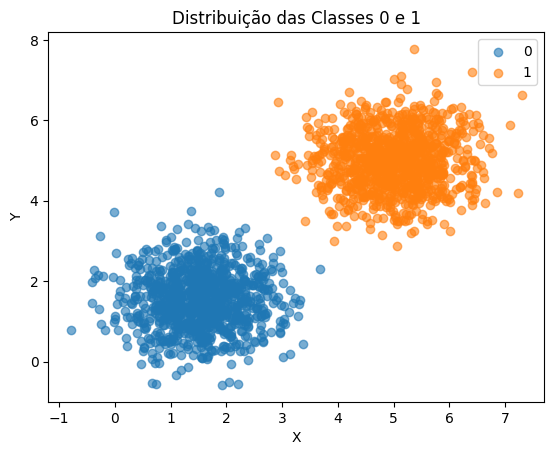

In [2]:
import matplotlib.pyplot as plt

plt.scatter(label_features[0][:,0], label_features[0][:,1], label='0', alpha=0.6)
plt.scatter(label_features[1][:,0], label_features[1][:,1], label='1', alpha=0.6)
plt.title('Distribuição das Classes 0 e 1')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

Analisando o gráfico, é facilmente preceptível que as classes 0 e 1 são passíveis de serem separadas por uma linha reta. Não é observada uma sobreposição dos dados, o que torna possível uma solução linear para a separação. Até existem alguns pontos das classes bem próximos um do outro, porém nada que impossibilite a soluçao linear.

Para a implementação do algoritmo de Perceptron, foi necessário agrupar ambas as classes em um vetor só, tanto para as variáveis independentes, como para a variável dependente. Essa manipulação foi feita utilizando a biblioteca *NumPy*.

In [3]:
X = np.vstack(label_features)
y = np.hstack(label_class)

Uma vez que Perceptron é um modelo que necessita de treinamento, como todo processo de treino e teste do modelo, é importante separar o dataset de implementação entre amostras de treino e teste, evitando *overfitting*. Para isso, foi utilizada a função `train_test_split` da biblioteca *Scikit-Learn*, que separa essas amostras com o cuidado de não embaralhar os pares (X,y) de cada observação, o que tornaria completamente inválidas as amostras.

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=RANDOM_SEED,
    shuffle=True
)

Com relação especificamente ao algoritmo Perceptron, o que foi feito aqui é uma implementação desse algoritmo matemático a partir de uma classe. Existem implementações do mesmo algoritmo prontas em bibliotecas famosas, como a *Scikit-Learn* `sklearn.linear_model.Perceptron()`. No entanto, como já apresentado, a ideia desse projeto como um todo é explorar o funcionamento base de uma rede neural, para entendimento completo do modelo, e também, aprendizado de implementação de linguagem de programação. Por isso, foi construída a seguinte classe:

In [5]:
np.random.seed(RANDOM_SEED)

class Perceptron:
    def __init__(
        self,
        x,
        y,
        weights=None,
        bias=None,
        eta: float = 0.01,
        att_bias: bool = False,
        max_epochs: int = 100
    ):
        self.x = x
        self.y = y
        
        n_features = x.shape[1]

        if weights is None:
            self.weights = np.random.random(n_features)
        else:
            self.weights = weights

        if bias is None:
            self.bias = np.random.random()
        else:
            self.bias = bias
        
        self.eta = eta
        self.att_bias = att_bias
        self.max_epochs = max_epochs

        self.accuracy_per_epoch = []
        self.updates_per_epoch = []
        self.converged = False
        self.epochs_run = 0

    def train(self, use_patience: bool = True, patience: int = 10, min_delta: int = 0):
        best_updates = np.inf
        best_weights = self.weights.copy()
        best_bias = float(self.bias)
        patience_count = 0
        early_stopped = False

        self.stop_reason = "max_epochs"
        self.converged = False
        self.accuracy_per_epoch = []
        self.updates_per_epoch = []

        for epoch in range(self.max_epochs):
            updates = 0

            indices = np.random.permutation(len(self.x))
            x_shuffled = self.x[indices]
            y_shuffled = self.y[indices]

            for x_i, y_i in zip(x_shuffled, y_shuffled):
                y_pred = 1 if (np.dot(x_i, self.weights) + self.bias) >= 0 else 0
                error = y_i - y_pred
                if error != 0:
                    updates += 1
                    self._rebalance(x=x_i, error=error)

            acc = 1.0 - (updates / len(self.y))
            self.accuracy_per_epoch.append(acc)
            self.updates_per_epoch.append(updates)
            self.epochs_run = epoch + 1

            if updates == 0:
                self.converged = True
                self.stop_reason = "Sem erros (linearmente separável)"
                best_updates = 0
                best_weights = self.weights.copy()
                best_bias = float(self.bias)
                break

            if use_patience:
                improvement = best_updates - updates
                if improvement >= min_delta:
                    best_updates = updates
                    best_weights = self.weights.copy()
                    best_bias = float(self.bias)
                    patience_count = 0
                else:
                    patience_count += 1
                    if patience_count >= patience:
                        self.stop_reason = (
                            f"Parada adiantada (sem melhora ≥ {min_delta} por {patience} épocas)"
                        )
                        early_stopped = True
                        break

        if use_patience and early_stopped and best_updates < np.inf:
            self.weights = best_weights
            self.bias = best_bias
    
    def predict(self, X_test=None, y_test=None):
        if X_test is None:
            raise ValueError("Entre com o X_test")

        scores = X_test @ self.weights + self.bias
        y_pred = (scores >= 0).astype(int)

        if y_test is not None:
            acc = (y_pred == y_test).mean()
            return y_pred, acc
        return y_pred

    def _rebalance(self, x, error):
        if error != 0:
            self.weights += self.eta * error * x
            if self.att_bias:
                self.bias += self.eta * error

De modo geral, o funcionamento do Perceptron nada mais é do que um modelo linear como a Regressão Linear. Existem as variáveis de entrada, independentes (*features*) e a variável de saída, dependente (*target*). Para cada feature utilizada na entrada do perceptron, um peso é criado para ela dentro do modelo. Além dos pesos das features, o modelo também possui um *bias*, ou seja, um peso que ajusta de certa forma o resultado linear dos pesos e features. Para cada observação apresentada para o algoritmo, esse faz um produto linear entre as variáveis independentes e os pesos, e soma o *bias*. Após isso, ele compara o resultado encontrado, com o esperado no target, e a partir disso, atualiza os pesos buscando reduzir o erro em uma próxima exposição a uma observação.

O formato de atualização dos pesos, no modelo de Percetron, possui uma peculiaridade, pois a atualização dos seus pesos não necessariamente busca a equidade entre o target previsto e o target esperado naquela observação, uma vez que os pesos são ponderados/atualizados tanto baseados no erro calculado, como também em um hiperparâmetro, a *taxa de aprendizado* (&eta;). A atualização dos pesos de acordo com o erro encontrado em uma determinada observação é atualizado por:

$$
\mathbf{w} \leftarrow \mathbf{w} + \eta \cdot \text{error} \cdot \mathbf{x}^{(i)}
$$

$$
b \leftarrow b + \eta \cdot \text{error}
$$

Após o treinamento com observação, outra é submetida para predição, e assim é percorrida toda a amostra de treinamento disponível. Ao acabar o conjunto de treinamento, esse tem a ordem das observações embaralhada, e uma nova *época* de treinamento é iniciada. Ou seja, a cada passagem completa pelo conjunto de treinamento, é contabilizada o que é denominado *época*.

Com relação ao critério de parada do treinamento, esse pode ser feito de duas formas: uma sendo quando o modelo convergir no conjunto de treinamento, isto é, quando o modelo passar por uma época inteira e não tiver nenhuma atualização dos pessos, uma vez que ele previu todos os targets corretamente; a outra forma é estabelecendo um critério de parada arbitrário. No primeiro caso analisado, o conjunto de dados é linearmente separável, logo, o modelo converge no conjunto de treinamento, parando esse. No entanto, no segundo momento de análise, quando foi aplicado o modelo sobre um conjunto de dados impossível de ser separado de forma linear, foi necessário implementar um método de decisão de parada no treinamento. A classe apresentada conta com o método conhecido como *patience*. Nesse esquema, define-se um número $K$ de épocas de “paciência” e uma métrica de melhoria, por exemplo, menor número de atualizações na época. A cada época sem melhoria, incrementa-se um contador; quando há melhoria, o contador é zerado. O treinamento é interrompido ao atingir $K$ épocas sem avanço.

In [6]:
np.random.seed(RANDOM_SEED)
weights = np.random.random(2)
bias = np.random.random(1)

print(f"Initial weights: {weights}")
print(f"Initial bias: {bias}")

Initial weights: [0.37454012 0.95071431]
Initial bias: [0.73199394]


Aqui então, foram sorteados dois pesos, por conta da distribuição utilizada, possuir 2 dimensões, e também um *bias*. Novamente, foi utilizada a *seed* (42).

In [7]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
np.random.seed(RANDOM_SEED)

prcpt_linear = Perceptron(x=X_train, y=y_train, weights=weights, bias=bias, eta=0.01, att_bias=True)
prcpt_linear.train()

print("Convergiu:", prcpt_linear.converged)
print("Épocas:", prcpt_linear.epochs_run)
print("Acurácia por época:", prcpt_linear.accuracy_per_epoch)
print("Atualizações por época:", prcpt_linear.updates_per_epoch)

Convergiu: True
Épocas: 3
Acurácia por época: [0.8821428571428571, 0.9885714285714285, 1.0]
Atualizações por época: [165, 16, 0]


Ao inicializar a classe do Perceptron com o conjunto de treinamento e os pesos sorteados, o método de `.train()` executa o passo a passo de treinamento explicado anteriormente. Como era esperado, nessa distribuição o modelo convergiu e convergiu rápido. Após 2 épocas de treinamento, o modelo já estava acertando todos os targets. Ao aplicar esse modelo treinado no dataset como um todo, foi obtida uma acurácia de 99,9% o que é muito bom, porém de certa forma pode apresentar um certo *overfitting*.

In [8]:
y_pred_full, acc_full = prcpt_linear.predict(X_test=X, y_test=y)
print(f"Acurácia no dataset completo: {acc_full * 100:.4f}%")

Acurácia no dataset completo: 99.9000%


Além de analisar a acurácia, pode-se observar como os dados estão sendo separados literalmente pela linha formada pelos pesos do modelo.

In [9]:
w = prcpt_linear.weights
b = float(np.squeeze(prcpt_linear.bias))

x_min = X[:, 0].min() - 0.5
x_max = X[:, 0].max() + 0.5
xs = np.linspace(x_min, x_max, 400)

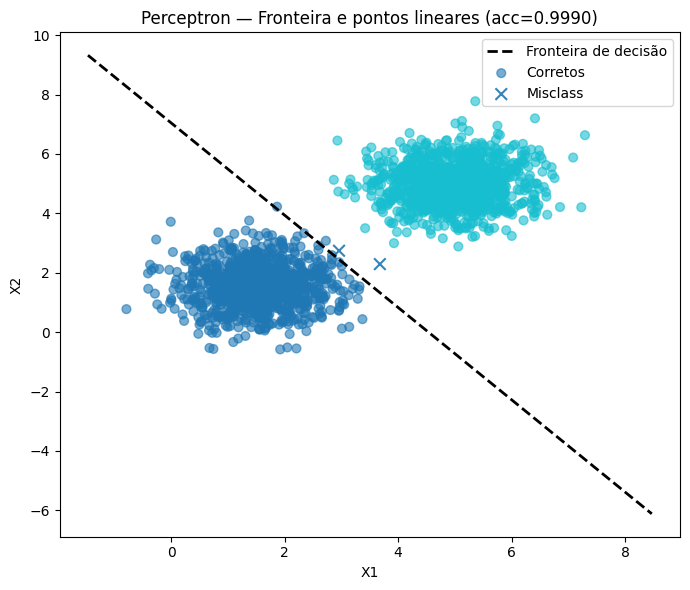

In [25]:
plt.figure(figsize=(7, 6))

if abs(w[1]) > 1e-12:
    ys = -(w[0] / w[1]) * xs - b / w[1]
    plt.plot(xs, ys, '--', linewidth=2, label="Fronteira de decisão", c='black')
else:
    x_v = -b / w[0]
    plt.axvline(x_v, linewidth=2, label="Fronteira de decisão", c='black', linestyle='--')

mis = (y_pred_full != y)

plt.scatter(
    X[~mis, 0], X[~mis, 1],
    c=y[~mis],
    cmap=plt.get_cmap("tab10", 2),
    marker="o", s=40, alpha=0.6,
    label="Corretos"
)

plt.scatter(
    X[mis, 0], X[mis, 1],
    c=y[mis],
    cmap=plt.get_cmap("tab10", 2),
    marker="x", s=70, alpha=0.9,
    label="Misclass"
)

plt.title(f"Perceptron — Fronteira e pontos lineares (acc={acc_full:.4f})")
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend()
plt.tight_layout()
plt.show()

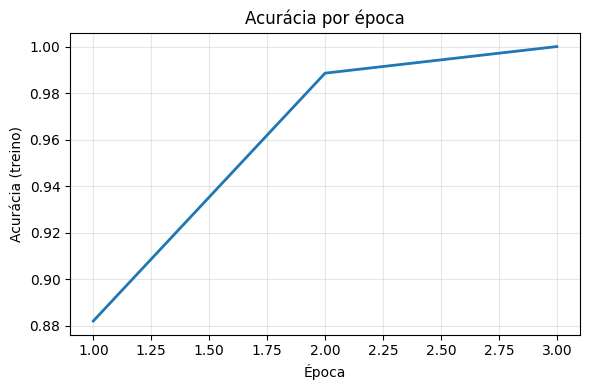

In [11]:
plt.figure(figsize=(6, 4))
plt.plot(np.arange(1, prcpt_linear.epochs_run + 1), prcpt_linear.accuracy_per_epoch, linewidth=2)
plt.xlabel("Época")
plt.ylabel("Acurácia (treino)")
plt.title("Acurácia por época")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Pela análise gráfica, é possível compreender que apenas dois pontos foram classificados de forma errada, e como já era previsto, os dados eram possíveis de serem separados linearmente. Por fatos como esse que é possível explicar o modelo alcançar uma taxa de erro zero no conjunto de treinamento tão rápido, apenas duas épocas de treinamento. Essa facilidade e taxa alta de acerto no conjunto de dados como um todo não é observado em distribuições de dados mais complexas. É nessa condição que a próxima análise trabalha.

## Distribuição linearmente inseparável

Para a investigação de dados linearmente inseparáveis, foram criadas duas classes de dados, com 1000 observações em cada, seguindo as seguintes distribuições:

- Class 0:

    Mean = $[3, 3]$,

    Covariance matrix = $[[1.5, 0], [0, 1.5]]$ (i.e., higher variance of 1.5 along each dimension).

- Class 1:

    Mean = $[4, 4]$,

    Covariance matrix = $[[1.5, 0], [0, 1.5]]$.  


Novamente, para possível reprodutibilidade, na geração dos dados/distribuições, foi utilizada a função `np.random.seed()`, com a *RANDOM_SEED (42)*.

In [12]:
np.random.seed(RANDOM_SEED)
classes = [0, 1]

mean = [[3,3], [4,4]]
sigma = [
    [
        [1.5,0],
        [0,1.5],
    ],
    [
        [1.5,0],
        [0,1.5],
    ]
]

label_features_non_linear = []
label_class_non_linear = []

for classe in classes:
    features = np.random.multivariate_normal(mean[classe], sigma[classe], size=N)

    label_features_non_linear.append(features)
    label_class_non_linear.append([classe] * N)

Utilizando a biblioteca Matplotlib.PyPlot para visualizar como ficaram as distribuições de cada uma das classes, podemos observar:

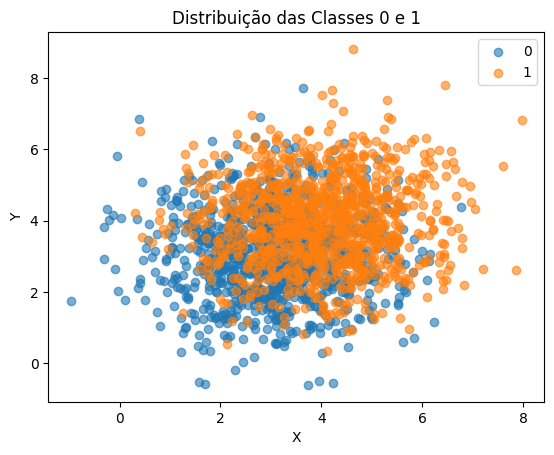

In [13]:
plt.scatter(label_features_non_linear[0][:,0], label_features_non_linear[0][:,1], label='0', alpha=.6)
plt.scatter(label_features_non_linear[1][:,0], label_features_non_linear[1][:,1], label='1', alpha=.6)
plt.title('Distribuição das Classes 0 e 1')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

Analisando o gráfico, fica claro que nesse segundo caso as classes estão completamente sobrepostas, inviabilizando a separação puramente linear. Por esse fato que o método de parada no treinamento do algoritmo Perceptron foi necessário. Novamente para implementação é necessário agrupar as classes.

In [14]:
X_non_linear = np.vstack(label_features_non_linear)
y_non_linear = np.hstack(label_class_non_linear)

Foi feita da mesma forma a separação dos conjuntos de treino e teste, justamente para ser possível a comparação dos desempenhos.

In [15]:
X_train_non_linear, X_test_non_linear, y_train_non_linear, y_test_non_linear = train_test_split(
    X_non_linear, y_non_linear,
    test_size=0.3,
    random_state=RANDOM_SEED,
    shuffle=True
)


Na geração dos pesos, foi utilizada a mesma *seed*, logo era de se esperar que os pesos iniciais em ambos os modelos fosse idênticos, incluindo o *bias*.

In [16]:
np.random.seed(RANDOM_SEED)
weights = np.random.random(2)
bias = np.random.random(1)

print(f"Initial weights: {weights}")
print(f"Initial bias: {bias}")

Initial weights: [0.37454012 0.95071431]
Initial bias: [0.73199394]


Como já discutido no gráfico, os dados são impossíveis de serem separados de forma linear, e portanto, caso o modelo seja treinado sem um método de parada antecipada, ele vai percorrer as 100 épocas de limite e pausar o treinamento sem convergir. Isto pois, em nenhum momento ele vai percorrer uma época inteira sem errar.

In [17]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
np.random.seed(RANDOM_SEED)

prcpt_non_linear_1 = Perceptron(x=X_train_non_linear, y=y_train_non_linear, weights=weights, bias=bias, eta=0.01, att_bias=True)
prcpt_non_linear_1.train(use_patience=False)

print("Convergiu:", prcpt_non_linear_1.converged)
print("Épocas:", prcpt_non_linear_1.epochs_run)

if not prcpt_non_linear_1.converged:
    print(prcpt_non_linear_1.stop_reason)

print("Acurácia por Época:", prcpt_non_linear_1.accuracy_per_epoch)
print("Atualizações por Época:", prcpt_non_linear_1.updates_per_epoch)

Convergiu: False
Épocas: 100
max_epochs
Acurácia por Época: [0.49142857142857144, 0.6035714285714286, 0.6057142857142856, 0.6278571428571429, 0.635, 0.6135714285714285, 0.6335714285714286, 0.6328571428571428, 0.6185714285714285, 0.6085714285714285, 0.62, 0.6071428571428572, 0.6478571428571429, 0.6242857142857143, 0.6242857142857143, 0.6278571428571429, 0.6435714285714286, 0.6292857142857142, 0.6428571428571428, 0.6135714285714285, 0.6192857142857142, 0.635, 0.615, 0.6178571428571429, 0.6235714285714286, 0.6185714285714285, 0.6264285714285714, 0.6107142857142858, 0.6028571428571429, 0.615, 0.6121428571428571, 0.6064285714285714, 0.6057142857142856, 0.6321428571428571, 0.6214285714285714, 0.6021428571428571, 0.6057142857142856, 0.5957142857142856, 0.6128571428571429, 0.6321428571428571, 0.6207142857142858, 0.5871428571428572, 0.6207142857142858, 0.63, 0.6392857142857142, 0.6192857142857142, 0.6235714285714286, 0.6207142857142858, 0.6242857142857143, 0.6092857142857142, 0.6321428571428571

Caso seja aplicado o método de parada *patience*, explicado anteriormente, o modelo parará de treina caso ele exceda o limite de rodadas sem melhora na métrica de análise. No caso dessa aplicação, a métrica utilizada foi a quantidade de atualizações feitas na época e a quantidade de épocas sem melhora nessa métrica foram de 30. Ou seja, o modelo parará de treinar caso ele passe 30 épocas com o número de atualizações feitas sendo maiores que as últimas 29 épocas.

Com esse método de parada implementado, o que acontece é que o modelo para de treinar apóos 49 épocas. Isto é, não existiram épocas com menos atualizações desde a 19ª rodada.

In [18]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
np.random.seed(RANDOM_SEED)

prcpt_non_linear_2 = Perceptron(x=X_train_non_linear, y=y_train_non_linear, weights=weights, bias=bias, eta=0.01, att_bias=True)
prcpt_non_linear_2.train(use_patience=True, patience=30)

print("Convergiu:", prcpt_non_linear_2.converged)
print("Épocas:", prcpt_non_linear_2.epochs_run)

if not prcpt_non_linear_2.converged:
    print(prcpt_non_linear_2.stop_reason)

print("Acurácia por Época:", prcpt_non_linear_2.accuracy_per_epoch)
print("Atualizações por Época:", prcpt_non_linear_2.updates_per_epoch)

Convergiu: False
Épocas: 49
Parada adiantada (sem melhora ≥ 0 por 30 épocas)
Acurácia por Época: [0.6021428571428571, 0.6307142857142858, 0.6135714285714285, 0.6378571428571429, 0.6385714285714286, 0.6114285714285714, 0.6221428571428571, 0.6228571428571428, 0.6307142857142858, 0.6042857142857143, 0.6292857142857142, 0.6178571428571429, 0.6335714285714286, 0.6021428571428571, 0.6178571428571429, 0.6257142857142857, 0.6435714285714286, 0.6285714285714286, 0.6464285714285714, 0.6278571428571429, 0.6228571428571428, 0.6328571428571428, 0.6028571428571429, 0.6135714285714285, 0.6185714285714285, 0.6257142857142857, 0.6285714285714286, 0.6057142857142856, 0.6128571428571429, 0.62, 0.62, 0.6114285714285714, 0.6007142857142858, 0.6271428571428572, 0.6428571428571428, 0.6121428571428571, 0.6228571428571428, 0.5971428571428572, 0.6128571428571429, 0.6164285714285714, 0.6214285714285714, 0.6035714285714286, 0.6257142857142857, 0.6307142857142858, 0.6264285714285714, 0.6085714285714285, 0.62642857

In [19]:
y_pred_full_non_linear, acc_full_non_linear = prcpt_non_linear_2.predict(X_test=X_non_linear, y_test=y_non_linear)
print(f"Acurácia no dataset completo: {acc_full_non_linear * 100:.4f}")

Acurácia no dataset completo: 64.6500


Por ser um conjunto de dados com mais sobreposição é possível perceber uma piora na acurácia como um todo, tanto nos treinamentos como no teste sob o conjunto de dados inteiro. Enquanto no primeiro exemplo foi possível alcaçar 99,9% de acurácia no dataset completo, nesse segundo, foi obtido apenas 64,65%

In [20]:
w = prcpt_non_linear_2.weights
b = float(np.squeeze(prcpt_non_linear_2.bias))

x_min = X_non_linear[:, 0].min() - 0.5
x_max = X_non_linear[:, 0].max() + 0.5
xs = np.linspace(x_min, x_max, 400)

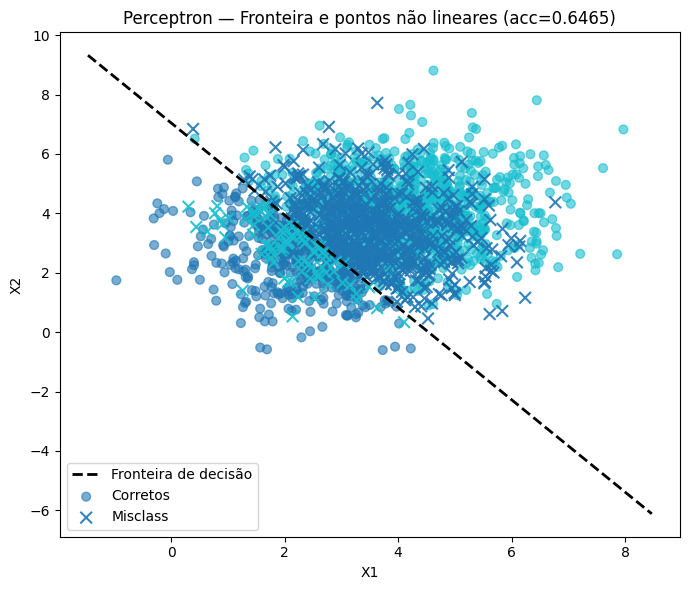

In [24]:
plt.figure(figsize=(7, 6))

if abs(w[1]) > 1e-12:
    ys = -(w[0] / w[1]) * xs - b / w[1]
    plt.plot(xs, ys, '--', linewidth=2, label="Fronteira de decisão", c='black')
else:
    x_v = -b / w[0]
    plt.axvline(x_v, linewidth=2, label="Fronteira de decisão", c='black', linestyle='--')

mis = (y_pred_full_non_linear != y_non_linear)

plt.scatter(
    X_non_linear[~mis, 0], X_non_linear[~mis, 1],
    c=y[~mis],
    cmap=plt.get_cmap("tab10", 2),
    marker="o", s=40, alpha=0.6,
    label="Corretos"
)

plt.scatter(
    X_non_linear[mis, 0], X_non_linear[mis, 1],
    c=y[mis],
    cmap=plt.get_cmap("tab10", 2),
    marker="x", s=70, alpha=0.9,
    label="Misclass"
)

plt.title(f"Perceptron — Fronteira e pontos não lineares (acc={acc_full_non_linear:.4f})")
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend()
plt.tight_layout()
plt.show()

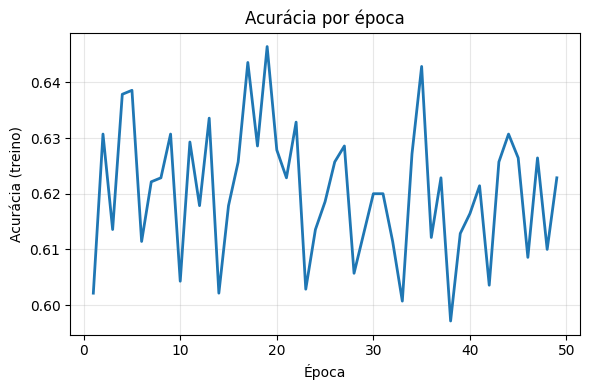

In [28]:
plt.figure(figsize=(6, 4))
plt.plot(np.arange(1, prcpt_non_linear_2.epochs_run + 1), prcpt_non_linear_2.accuracy_per_epoch, linewidth=2)
plt.xlabel("Época")
plt.ylabel("Acurácia (treino)")
plt.title("Acurácia por época")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Diferentemente do primeiro exemplo, nesse conjunto de casos, vários pontos foram classificados de forma errada. Além disso, analisando a acurácia ao longo dos treinamentos, percebe-se que: o modelo não convergiu; existiu uma maior variabilidade de resutlados, não sendo um progresso linear de melhora da acurácia. Logo, conclui-se que o Percetron realmente não consegue trabalhar com dados não lineares. Em meio a essa dificuldade, de lidar com dados não lineares, que surge a ideia do MPL (Multi-Layer Perceptron), um algoritmo capaz de combinar vários Perceptrons em diferentes camadas, o que transforma a capacidade de aprendizado e previsão dos dados do Perceptron.